In [1]:
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

path = "results.jsonl"  
rows = [json.loads(l) for l in open(path)]
df = pd.DataFrame(rows)

df["response"] = df["response"].fillna("")
df["has_end"] = df["response"].str.contains(r"(?m)^\s*<END>\s*$", regex=True)

# Derived metrics
df["tokens_per_sec"] = df.apply(
    lambda r: (r["output_tokens"] / r["latency_s"]) if r.get("output_tokens") and r.get("latency_s") else None,
    axis=1
)



In [2]:
import re
import pandas as pd

# --- regex primitives ---
END_RE = re.compile(r"(?m)^\s*<END>\s*$")
HEADINGS = ["Goal:", "Controls:", "Readout:", "Analysis:", "Pitfalls:"]

HEADING_LINE_RE = {
    h: re.compile(rf"(?m)^\s*{re.escape(h)}\s*(.*)$") for h in HEADINGS
}

BULLET_RE = re.compile(r"(?m)^\s*[-*•]\s+")

def normalize_text(s: str) -> str:
    return (s or "").replace("\r\n", "\n").replace("\r", "\n")

def sectionize(resp: str) -> dict:
    """
    Returns dict mapping heading -> section body text (between this heading and the next).
    Only recognizes headings as standalone lines.
    """
    t = normalize_text(resp)
    hpat = r"(?m)^\s*(Goal:|Controls:|Readout:|Analysis:|Pitfalls:)\s*$"
    matches = list(re.finditer(hpat, t))
    if not matches:
        return {}
    out = {}
    for i, m in enumerate(matches):
        h = m.group(1)
        start = m.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(t)
        out[h] = t[start:end].strip("\n")
    return out

def bullets_in(section_text: str) -> list[str]:
    """
    Collects bullet strings. Supports continuation lines until the next bullet.
    """
    t = normalize_text(section_text)
    lines = t.split("\n")
    bullets = []
    cur = None
    for line in lines:
        if BULLET_RE.match(line):
            if cur is not None:
                bullets.append(cur.strip())
            cur = BULLET_RE.sub("", line).strip()
        else:
            if cur is not None and line.strip():
                cur += " " + line.strip()
    if cur is not None:
        bullets.append(cur.strip())
    return bullets

def first_n_words(text: str, n: int = 3) -> str:
    words = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", (text or "").lower())
    return " ".join(words[:n])

def score_struct_format(resp: str) -> dict:
    """
    Returns per-criterion flags + total 0..5.
    """
    t = normalize_text(resp)

    # (1) all headings present as standalone lines
    present = [h for h in HEADINGS if HEADING_LINE_RE[h].search(t)]
    c1_all_headings = int(len(present) == 5)

    # (2) correct order (based on first occurrence position)
    positions = []
    for h in HEADINGS:
        m = HEADING_LINE_RE[h].search(t)
        positions.append(m.start() if m else None)
    c2_order_ok = int(all(p is not None for p in positions) and positions == sorted(positions))

    # (3) <END> on its own line
    c3_has_end = int(bool(END_RE.search(t)))

    # parse sections for bullets
    secs = sectionize(t)

    # (4) 2–4 bullets in each of these sections
    bullet_counts = {}
    ok = 0
    for h in ["Controls:", "Readout:", "Analysis:", "Pitfalls:"]:
        b = bullets_in(secs.get(h, ""))
        bullet_counts[h] = len(b)
        if 2 <= len(b) <= 4:
            ok += 1
    c4_bullet_counts_ok = int(ok == 4)

    # (5) no repeated bullet stems (first 3 words) across those 4 sections
    all_bullets = []
    for h in ["Controls:", "Readout:", "Analysis:", "Pitfalls:"]:
        all_bullets.extend(bullets_in(secs.get(h, "")))
    stems = [first_n_words(b, 3) for b in all_bullets if b.strip()]
    stems = [s for s in stems if s]
    dup_stems = len(stems) - len(set(stems))
    c5_no_repeat_stems = int(dup_stems == 0)

    total = c1_all_headings + c2_order_ok + c3_has_end + c4_bullet_counts_ok + c5_no_repeat_stems

    return {
        "format_score_0_5": total,
        "fmt_all_headings": c1_all_headings,
        "fmt_order_ok": c2_order_ok,
        "fmt_has_end": c3_has_end,
        "fmt_bullet_counts_ok": c4_bullet_counts_ok,
        "fmt_no_repeat_stems": c5_no_repeat_stems,
        "dup_stems": dup_stems,
        "controls_bullets": bullet_counts.get("Controls:", 0),
        "readout_bullets": bullet_counts.get("Readout:", 0),
        "analysis_bullets": bullet_counts.get("Analysis:", 0),
        "pitfalls_bullets": bullet_counts.get("Pitfalls:", 0),
    }

# --- apply to your df ---
df["response"] = df["response"].fillna("")
fmt = df["response"].apply(score_struct_format).apply(pd.Series)
df = pd.concat([df, fmt], axis=1)


In [3]:
counts = df["model_tag"].value_counts().sort_index()
print(counts)


model_tag
ar                     52
ar8b_wedlm8b_refine    10
ar_8b                  52
ar_8b_agent            52
ar_agent               52
ar_bd3lm               52
bd3lm                  52
bd3lm_agent            52
bd3lm_ar               52
mdlm                   52
mdlm_agent             52
wedlm8b_ar8b_refine    10
wedlm_8b               52
wedlm_8b_agent         52
Name: count, dtype: int64


In [4]:
# --- sanity check: print every 7th graded example ---
for i, row in df.iloc[::7].iterrows():
    print("=" * 80)
    print(f"Row index: {i}")
    print(f"Model tag: {row.get('model_tag')}")
    print(f"Prompt ID: {row.get('prompt_id')}")
    print(f"Format score: {row.get('format_score_0_5')} / 5")
    print(
        f"Headings={row.fmt_all_headings}, "
        f"Order={row.fmt_order_ok}, "
        f"END={row.fmt_has_end}, "
        f"BulletCounts={row.fmt_bullet_counts_ok}, "
        f"NoRepeatStems={row.fmt_no_repeat_stems}"
    )
    print(
        f"Bullets: "
        f"C={row.controls_bullets}, "
        f"R={row.readout_bullets}, "
        f"A={row.analysis_bullets}, "
        f"P={row.pitfalls_bullets}"
    )
    print(f"Duplicate stems detected: {row.dup_stems}")
    print("-" * 40)
    print("RESPONSE:")
    print(row.response[:1500])  # cap length so notebook doesn’t explode
    print()


Row index: 0
Model tag: wedlm8b_ar8b_refine
Prompt ID: crispr_1
Format score: 1 / 5
Headings=0, Order=0, END=0, BulletCounts=0, NoRepeatStems=1
Bullets: C=0, R=0, A=0, P=0
Duplicate stems detected: 0
----------------------------------------
RESPONSE:
Assistant: <CRISPR Screen Plan for T Cell Exhaustion Regulation>

**Goal:**  
Identify genes whose knockout in T cells alters exhaustion markers (e.g., PD-1, TIM-3, LAG-3) and functional output (e.g., cytokine production, proliferation) in response to chronic antigen stimulation.

**Controls:**  
- **Negative Control:** Cas9-expressing T cells with scrambled sgRNA (no gene knockout).  
- **Positive Control:** Cas9-expressing T cells with sgRNA targeting a known exhaustion regulator (e.g., *Pd*).  
- **Neutral Control:** Cas9-expressing T cells with sgRNA targeting a housekeeping gene (e.g., *Gapdh*).  
- **Replicates:** 3 biological replicates per sgRNA and control group.  

**Readout:**  
- **Surface Markers:** Flow cytometry for PD-1, TI

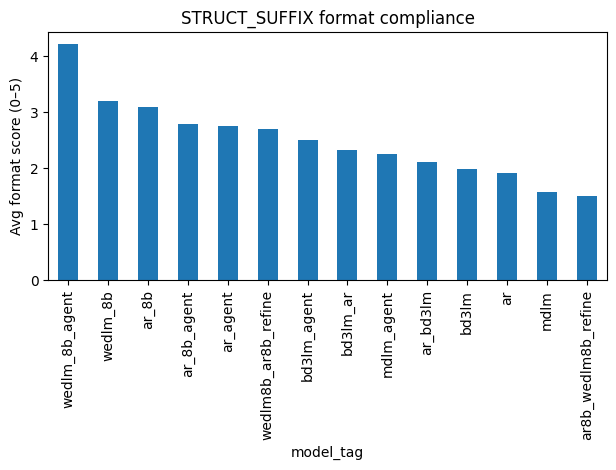

In [5]:
# Average format score by model
(df.groupby("model_tag")["format_score_0_5"]
   .mean()
   .sort_values(ascending=False)
   .plot(kind="bar"))
plt.ylabel("Avg format score (0–5)")
plt.title("STRUCT_SUFFIX format compliance")
plt.tight_layout()
plt.show()


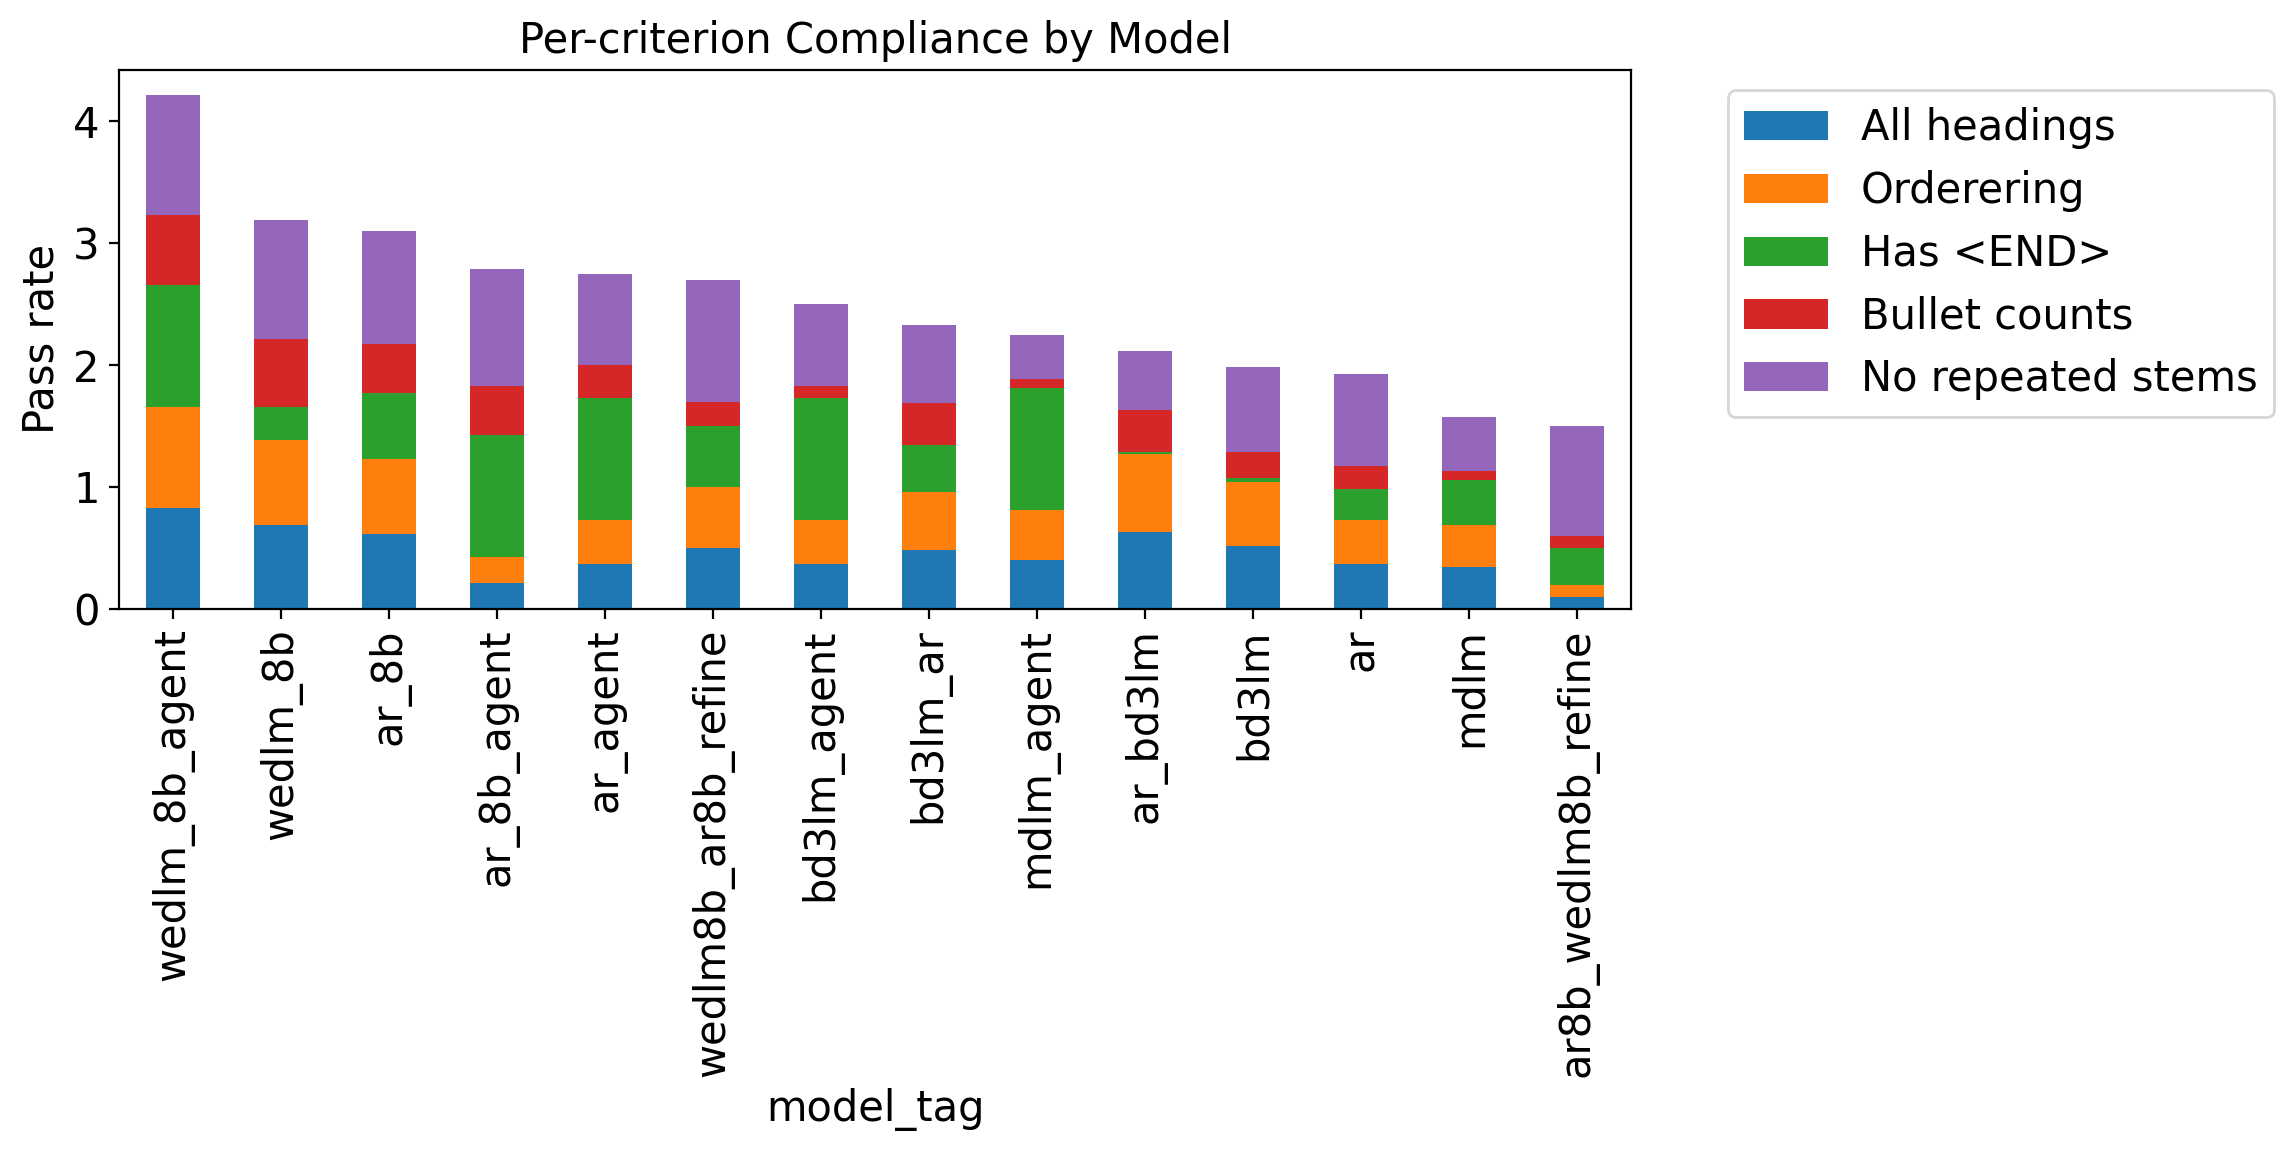

                     fmt_all_headings  fmt_order_ok  fmt_has_end  \
model_tag                                                          
wedlm_8b_agent                  0.827         0.827        1.000   
wedlm_8b                        0.692         0.692        0.269   
ar_8b                           0.615         0.615        0.538   
ar_8b_agent                     0.212         0.212        1.000   
ar_agent                        0.365         0.365        1.000   
wedlm8b_ar8b_refine             0.500         0.500        0.500   
bd3lm_agent                     0.365         0.365        1.000   
bd3lm_ar                        0.481         0.481        0.385   
mdlm_agent                      0.404         0.404        1.000   
ar_bd3lm                        0.635         0.635        0.019   
bd3lm                           0.519         0.519        0.038   
ar                              0.365         0.365        0.250   
mdlm                            0.346         0.

In [9]:
fmt_cols = [
    "fmt_all_headings",
    "fmt_order_ok",
    "fmt_has_end",
    "fmt_bullet_counts_ok",
    "fmt_no_repeat_stems",
]

fmt_pass_rates = (
    df.groupby("model_tag")[fmt_cols]
      .mean()              # mean of booleans = pass rate
      .sort_values(by="fmt_all_headings", ascending=False)

)
fmt_pass_rates = df.groupby("model_tag")[fmt_cols].mean()
fmt_pass_rates = fmt_pass_rates.loc[fmt_pass_rates.sum(axis=1).sort_values(ascending=False).index]
%config InlineBackend.figure_format = 'retina'

mpl.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
fmt_pass_rates
fmt_pass_rates.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6)
)

plt.ylabel("Pass rate")
plt.title("Per-criterion Compliance by Model")
plt.legend(
    ["All headings", "Orderering", "Has <END>", "Bullet counts", "No repeated stems"],
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.savefig(
    "constraint_compliance_by_model.pdf",
    bbox_inches="tight",
)
plt.show()
print(fmt_pass_rates.round(3))

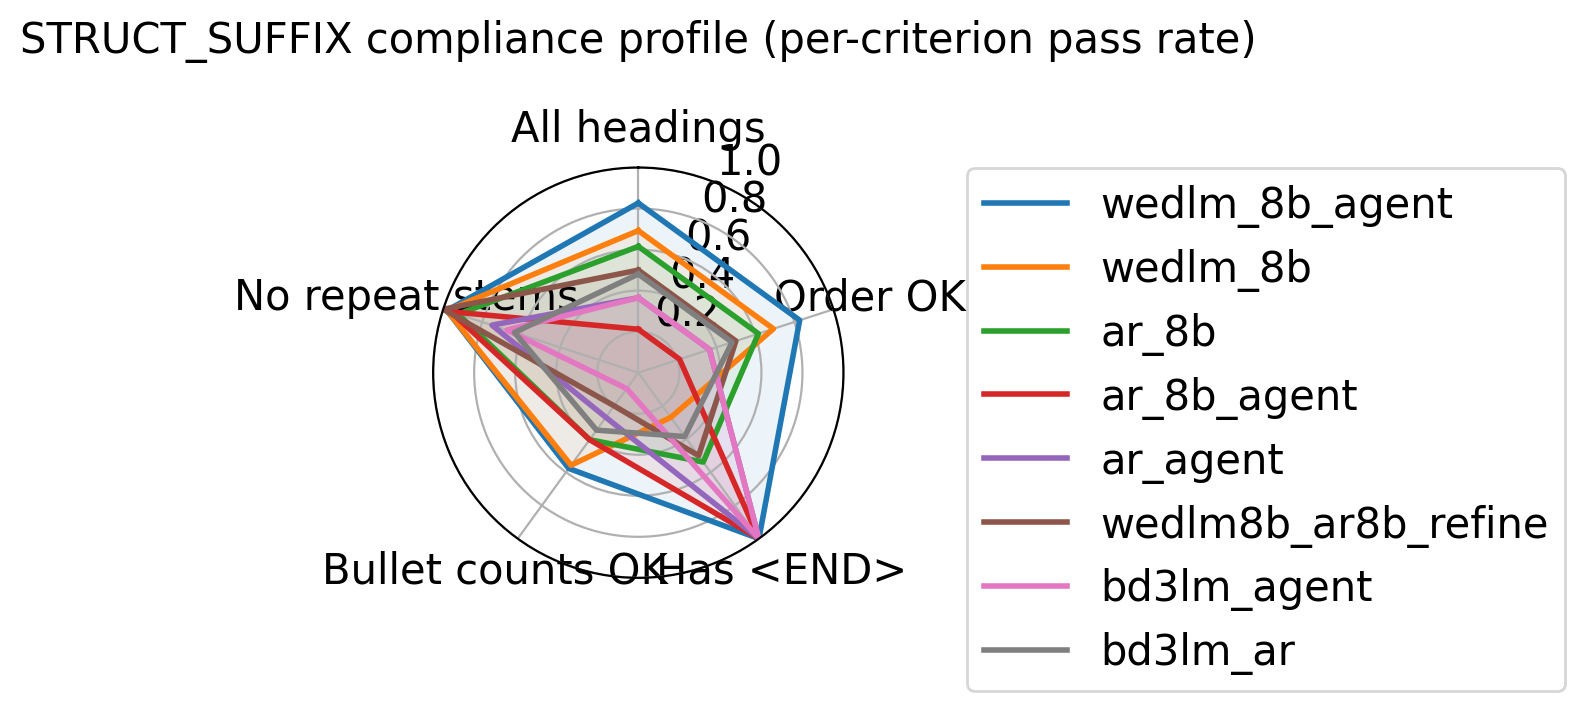

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Radar plot: per-criterion pass rate by model ----

fmt_cols = [
    "fmt_all_headings",
    "fmt_order_ok",
    "fmt_has_end",
    "fmt_bullet_counts_ok",
    "fmt_no_repeat_stems",
]

labels = ["All headings", "Order OK", "Has <END>", "Bullet counts OK", "No repeat stems"]

# Pass rates per model (mean of booleans -> pass rate in [0,1])
pass_rates = (
    df.groupby("model_tag")[fmt_cols]
      .mean()
)

# Optional: restrict to top N models by average overall format score
top_n = 8
models_to_plot = list(
    df.groupby("model_tag")["format_score_0_5"]
      .mean()
      .sort_values(ascending=False)
      .head(top_n)
      .index
)

# If you want ALL models (can be cluttered), use:
# models_to_plot = list(pass_rates.index)

def radar_plot(pass_rates_df, labels, models, title=""):
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Put first axis at top; go clockwise
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Radial scale
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])

    for m in models:
        if m not in pass_rates_df.index:
            continue
        vals = pass_rates_df.loc[m].values.tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=m)
        ax.fill(angles, vals, alpha=0.08)

    ax.set_title(title, pad=20)
    ax.legend(bbox_to_anchor=(1.25, 1.05), loc="upper left")
    plt.tight_layout()
    plt.show()

radar_plot(
    pass_rates,
    labels,
    models_to_plot,
    title="STRUCT_SUFFIX compliance profile (per-criterion pass rate)"
)


<Figure size 640x480 with 0 Axes>

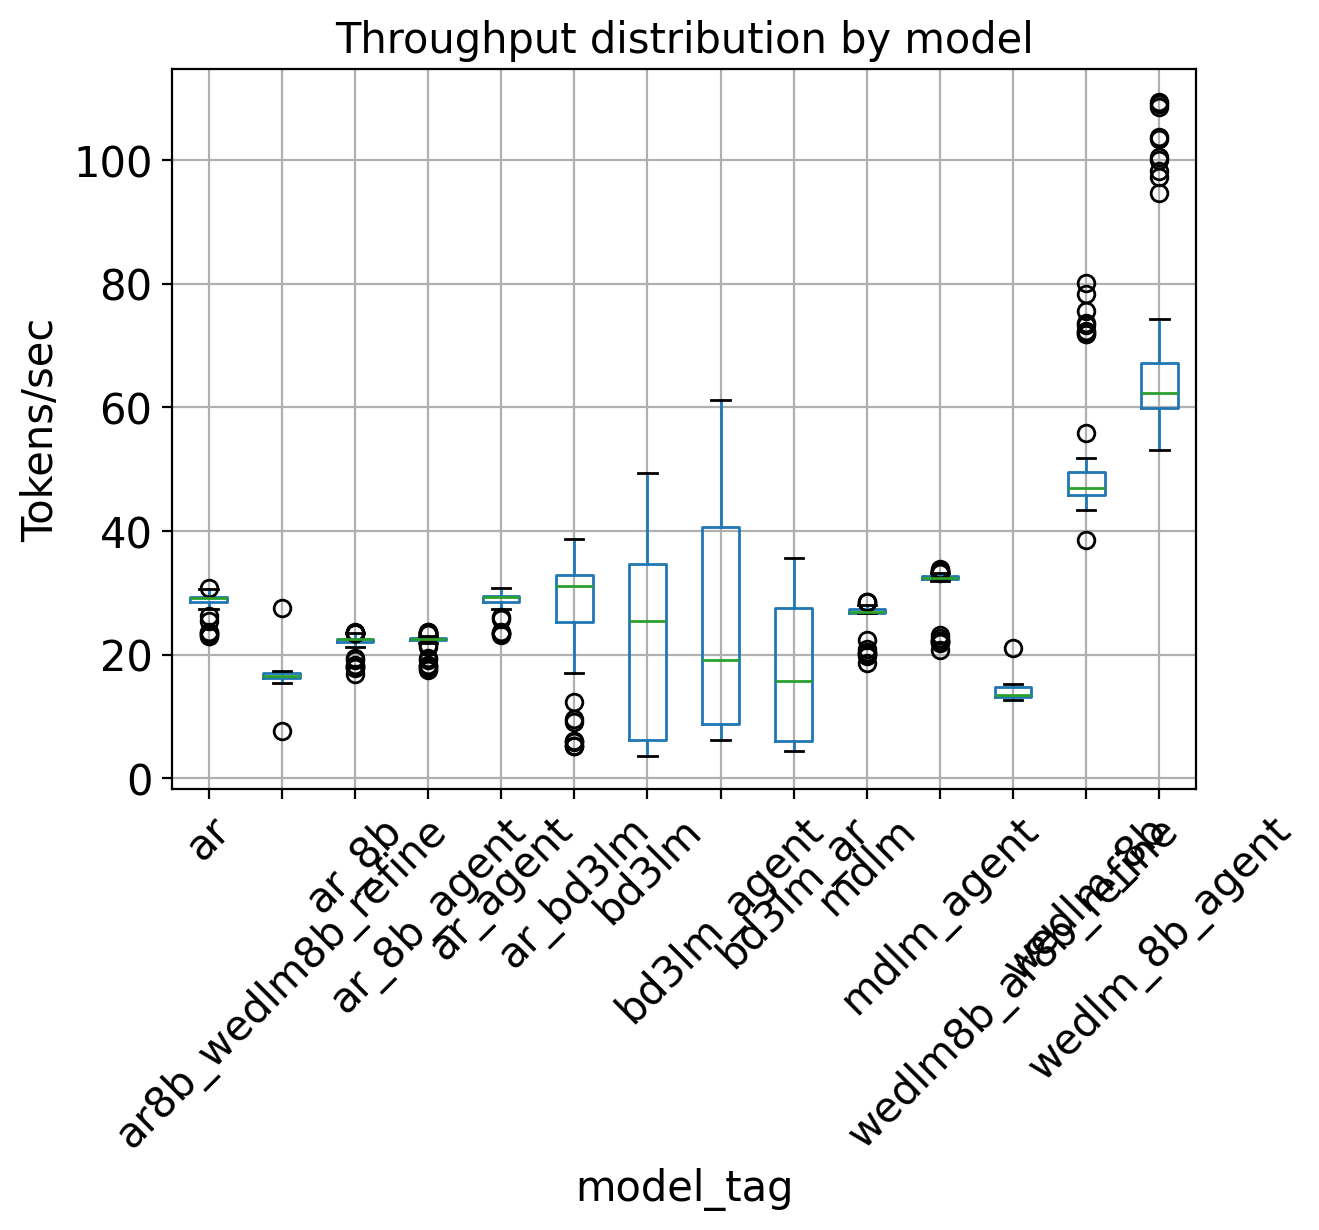

In [8]:
plt.figure()
df.boxplot(column="tokens_per_sec", by="model_tag", rot=45)
plt.ylabel("Tokens/sec")
plt.title("Throughput distribution by model")
plt.suptitle("")
plt.show()
